In [11]:
import warnings
warnings.filterwarnings("ignore")
import time,math
import numpy as np
from functions import cameraMatrix_cam1,cameraMatrix_cam2
from cv2 import circle,triangulatePoints,cvtColor,line,COLOR_GRAY2BGR,computeCorrespondEpilines
from myLib import isCollinear,isEqual,swapElements,getSignal,getOrder,reshapeCoord,findNearestC,myProjectionPoints
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
import random
from myLib import estimateFundMatrix_8norm,decomposeEssentialMat


In [12]:
df1,df2 = np.genfromtxt('cam1.csv', delimiter=','),np.genfromtxt('cam2.csv', delimiter=',')
maxTime,maxFrame = max(df1[-1][-2],df2[-1][-2]),max(df1[-1][-1],df2[-1][-1])
print('Maximum captured timestamp: '+str(round(maxTime/1e6,2))+' seconds')
print('#'+str(int(maxFrame))+' frames were captured')
dfCSV = [df1,df2]
verbose = False

Maximum captured timestamp: 89.92 seconds
#3498 frames were captured


In [13]:
def orderCenterCoord(centerCoord, prevCenterCoord, otherCamOrder = 0):
    centerX, centerY = reshapeCoord(centerCoord)
    # if it is the first image of the sequence
    if len(prevCenterCoord) == 0:  
        order,_ =  getOrder(centerX,centerY)  
        # if it is the second camera
        if otherCamOrder != 0:  
            # if the markers are wrong, swap the extremities
            signal, valid = getSignal(centerX[order[0]], centerX[order[2]],5)
            if signal != otherCamOrder and valid: order = swapElements(order, 0, 2)    
        else:        
            # get base for comparision (first camera only)        
            otherCamOrder,_ = getSignal(centerX[order[0]], centerX[order[2]])
        # sort centers        
        if np.linalg.norm(centerX[order[0]]-centerX[order[1]])>np.linalg.norm(centerX[order[2]]-centerX[order[1]]):
            sortedCenterCoord = np.array((centerCoord[order[0]], centerCoord[order[1]], centerCoord[order[2]]))
        else: sortedCenterCoord = np.array((centerCoord[order[2]], centerCoord[order[1]], centerCoord[order[0]]))
    else:
        # first reshape array of coordinates
        prevCenterX,prevCenterY = reshapeCoord(prevCenterCoord)
        # distance from marker A/B of previous img to center coordiantes of actual img
        distA = np.sqrt(np.power(np.subtract(prevCenterX[0], centerX), 2) + np.power(np.subtract(prevCenterY[0], centerY), 2))
        distB = np.sqrt(np.power(np.subtract(prevCenterX[1], centerX), 2) + np.power(np.subtract(prevCenterY[1], centerY), 2))
        # nearest marker from A is selected and removed as marker B candidate
        nearestA = np.argmin(distA)
        distBCopy = np.delete(distB, nearestA)
        # nearest marker from B is selected and removed as marker C candidate
        nearestBCopy = np.argmin(distBCopy)
        nearestB, = np.where(distB == distBCopy[nearestBCopy])
        distBCopy = np.delete(distBCopy, nearestBCopy)
        # get the missing marker position in array
        nearestC = findNearestC(nearestA, nearestB[0])
        # sort centers        
        sortedCenterCoord = [centerCoord[nearestA], centerCoord[nearestB[0]], centerCoord[nearestC]]
        # check if the ordering is ok
        centerX, centerY = reshapeCoord(sortedCenterCoord)
        prevOrder,axisPrev = getOrder(prevCenterX,prevCenterY)
        order,_ =  getOrder(centerX,centerY,baseAxis=True,axis=axisPrev)
        if (order[1] != 1) or (order[2] != prevOrder[2]):
            if prevOrder[0] == 2: order = swapElements(order,0,2) #if is decreasing, swap                
            sortedCenterCoord = np.array((sortedCenterCoord[order[0]], sortedCenterCoord[order[1]], sortedCenterCoord[order[2]]))
    return sortedCenterCoord, otherCamOrder



In [23]:
counter,i,lastTime = np.zeros(2,dtype=np.int32),np.zeros(2,dtype=np.int32),np.zeros(2,dtype=np.int32)
missed,invalid,swap = np.zeros(2,dtype=np.int32),np.zeros(2,dtype=np.int32),np.zeros(2,dtype=np.int32)
lastImgNumber = np.zeros(2,dtype=np.int32)
certainty,intervals,timeIntervals = np.zeros(2,dtype=np.bool8),[[],[]],[[],[]]
dfOrig,tol = [[],[]],0.25

while i[0]!=df1.shape[0] or i[1]!=df2.shape[0]:
    # get random number
    if i[0]==df1.shape[0]: idx = 1
    elif i[1]==df2.shape[0]: idx = 0
    else: idx = random.randint(0,1)
    # get points
    undCoord,time,imgNumber = dfCSV[idx][i[idx]][0:6].reshape(-1,2),dfCSV[idx][i[idx]][6],dfCSV[idx][i[idx]][7]
    i[idx]+=1
    # add proccesing per occlusion here
    # if ts if not read corectly, discard
    if counter[idx]:
        if time-lastTime[idx]>1e9: 
            if verbose: print('time missmatch')
            missed[idx]+=1
            continue
    # check if sequence is valid
    if imgNumber>lastImgNumber[idx]+1: invalid[idx] = imgNumber-lastImgNumber[idx]
    # order markers per proximity and check collinearity
    if isCollinear(*undCoord) and not isEqual(undCoord,5) and not np.any(undCoord<0):     
        if invalid[idx]>=10 or not counter[idx]: 
            if certainty[idx]:
                beg,end = intervals[idx][-1],counter[idx]-1
                timeIntervals[idx].append([dfOrig[idx][beg][6],dfOrig[idx][end][6]])
            prev,certainty[idx] = [],False
            intervals[idx].append(counter[idx])
        else: prev = np.array(dfOrig[idx][-1][0:6]).reshape(1,-2)
        undCoord, _ = orderCenterCoord(undCoord,prev)
        undCoord = np.array(undCoord)
    else: 
        if verbose: print('not collinear or equal centroids')
        missed[idx]+=1
        invalid[idx]+=1
        continue
    # update loop variables
    lastTime[idx],lastImgNumber[idx],invalid[idx] = time,imgNumber,0
    counter[idx]+=1
    dfOrig[idx].append(np.hstack((undCoord.reshape(6),time)))
    # check if ABC is in order smaller to largest
    if not certainty[idx]:
        for [A,B,C] in undCoord.reshape([-1, 3, 2]):
            if np.linalg.norm(A-B)/np.linalg.norm(C-B)>(2-tol) and np.linalg.norm(A-B)>20:
                swap[idx] += 1
                if swap[idx]>2: 
                    swap[idx],certainty[idx] = 0,True
                    dfOrig[idx][intervals[idx][-1]:counter[idx]][0:2],dfOrig[idx][intervals[idx][-1]:counter[idx]][4:6]=dfOrig[idx][intervals[idx][-1]:counter[idx]][4:6],dfOrig[idx][intervals[idx][-1]:counter[idx]][0:2]
            if np.linalg.norm(C-B)/np.linalg.norm(A-B)>(2-tol) and np.linalg.norm(C-B)>20: certainty[idx] = True

# get last interval
for idx in range(2):
    if certainty[idx]:
        beg,end = intervals[idx][-1],counter[idx]-1
        timeIntervals[idx].append([dfOrig[idx][beg][6],dfOrig[idx][end][6]])    
    dfOrig[idx] = np.array(dfOrig[idx])

# compute valid time intersection for interpolation
intersections = [[max(first[0], second[0]), min(first[1], second[1])]  
                    for first in timeIntervals[0] for second in timeIntervals[1]  
                    if max(first[0], second[0]) <= min(first[1], second[1])]

In [24]:
step = 1/100
dfInterp = np.zeros((int(120/step),2*6+1))
dfInterp[:,-1] = np.linspace(0,120,int(120/step))

for [beg,end] in intersections:
    for idx in range(2):
        validIdx = [i for i in range(0,len(dfOrig[idx])) if beg<=dfOrig[idx][i][-1]<=end]
        coord,time = dfOrig[idx][validIdx,0:6],dfOrig[idx][validIdx,6]/1e6
        lowBound,highBound = math.ceil(time[0]/step),math.floor(time[-1]/step)
        print('interpolated #'+str(idx+1)+' from '+str(round(lowBound*step,2))+'s to '+str(round(highBound*step,2))+'s')
        tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
        if time.shape[0]<=2: continue
        ff = CubicSpline(time,coord,axis=0)
        dfInterp[tNew,int(idx*6):int(idx*6+6)] = ff(tNew*step)

dfInterp = np.delete(dfInterp,np.unique([i for i in range(0,dfInterp.shape[0]) for idx in range(2) if not np.any(dfInterp[i][idx*6:idx*6+6])]),axis=0)
centroids1,centroids2 = dfInterp[:,0:6].reshape(-1,2),dfInterp[:,6:12].reshape(-1,2)

interpolated #1 from 0.03s to 10.34s
interpolated #2 from 0.03s to 10.32s
interpolated #1 from 10.63s to 13.54s
interpolated #2 from 10.63s to 13.54s
interpolated #1 from 14.17s to 22.81s
interpolated #2 from 14.15s to 22.81s
interpolated #1 from 23.57s to 26.69s
interpolated #2 from 23.55s to 26.66s
interpolated #1 from 27.42s to 28.63s
interpolated #2 from 27.42s to 28.63s
interpolated #1 from 40.44s to 42.55s
interpolated #2 from 40.44s to 42.53s
interpolated #1 from 42.81s to 48.73s
interpolated #2 from 42.81s to 48.73s
interpolated #1 from 49.29s to 51.88s
interpolated #2 from 49.26s to 51.85s
interpolated #1 from 52.74s to 59.37s
interpolated #2 from 52.74s to 59.37s
interpolated #1 from 59.81s to 60.85s
interpolated #2 from 59.78s to 60.82s
interpolated #1 from 61.48s to 66.42s
interpolated #2 from 61.48s to 66.4s
interpolated #1 from 67.25s to 73.04s
interpolated #2 from 67.26s to 73.02s
interpolated #1 from 74.05s to 76.79s
interpolated #2 from 74.05s to 76.77s
interpolated #1

In [25]:
# get fundamental and essential matrices
F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2))
E = np.matmul(cameraMatrix_cam2.T, np.matmul(F, cameraMatrix_cam1))
print("\nEssenc. Mat.\n", E.round(4))
# decompose to rotation and translation between cameras
R, t = decomposeEssentialMat(E, cameraMatrix_cam1, cameraMatrix_cam2, np.array(centroids1), np.array(centroids2))
if np.any(np.isnan(R)): print('no valid rotation matrix')
else:
    print("\nRot. Mat.\n", R.round(4))
    print("\nTrans. Mat.\n", t.round(4))

Fund. Mat.
 [[ 0.     -0.     -0.0015]
 [-0.     -0.      0.0094]
 [-0.001  -0.0018  1.    ]]
avg x'Fx=0: 0.46330796094927207
max x'Fx=0: 1.985677038961982

Essenc. Mat.
 [[ 0.0251 -3.8018 -3.0089]
 [-3.7921 -0.4843  4.4793]
 [-2.4222 -3.8868  0.06  ]]

Rot. Mat.
 [[-0.1119 -0.597   0.7944]
 [ 0.5534  0.6266  0.5488]
 [-0.8254  0.5011  0.2602]]

Trans. Mat.
 [[-0.62   -0.4253  0.6594]]


Scale between real world and triang. point cloud is:  402.21
L_AC >> mean = 15.6909cm, std. dev = 0.2757cm, rms = 0.2759cm
L_AB >> mean = 10.1656cm, std. dev = 0.193cm, rms = 0.1961cm
L_BC >> mean = 5.5274cm, std. dev = 0.1016cm, rms = 0.1052cm
Images distant more than 1% from the real value = 3979/6872


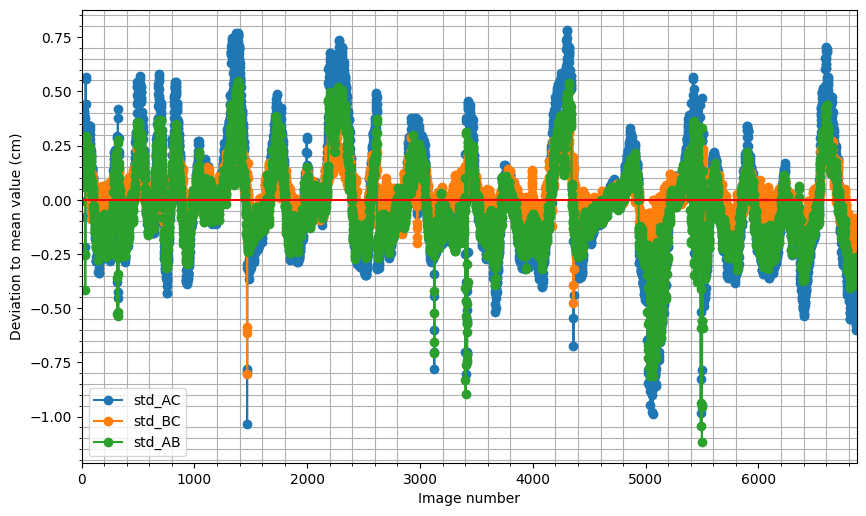

In [31]:
P1,P2 = np.hstack((cameraMatrix_cam1, [[0.], [0.], [0.]])),np.matmul(cameraMatrix_cam2, np.hstack((R, t.T)))
projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T
if points3d[0, 2] < 0: points3d = -points3d
tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx = 0,15.7,10.2,5.5,[],[],[],0,[]
# compute sdt deviation and plot beautiful stuff
for [A, B, C] in points3d.reshape([-1, 3, 3]):
    L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
    if L_rec_AB<L_rec_BC: L_rec_AB,L_rec_BC=L_rec_BC,L_rec_AB
    tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
    k = k + 3
    lamb = tot/k
    L_AC_vec.append(L_rec_AC)
    L_BC_vec.append(L_rec_BC)
    L_AB_vec.append(L_rec_AB)
print('Scale between real world and triang. point cloud is: ', lamb.round(2))
print('L_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
print('L_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
print('L_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
fig = plt.figure(figsize=(10, 6), dpi=100)
L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
plt.plot(L_AC_vec_plot, '-o', label="std_AC")
plt.plot(L_BC_vec_plot, '-o', label="std_BC")
plt.plot(L_AB_vec_plot, '-o', label="std_AB")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.grid()
#plt.axvline(x=853, c='r', linestyle='--', label="image 960")
plt.xlabel("Image number")
plt.ylabel("Deviation to mean value (cm)")
plt.legend()
ax = fig.axes
ax[0].minorticks_on()
plt.grid(which='both')
plt.xlim(0,len(L_AC_vec)-1)
points3d_new,i,k= points3d*lamb,0,0
for [A, B, C] in points3d_new.reshape([-1, 3, 3]):
    L_reconst = np.sqrt(np.sum((A-C)**2, axis=0))
    valid = abs(L_real_AC-L_reconst)/L_real_AC < 0.01
    if not valid: 
        i = i + 1
        false_idx.extend((k,k+1,k+2))
    k+=3

print("Images distant more than 1% from the real value = " + str(i)+'/'+str(int(points3d.shape[0]/3)))
plt.draw()
plt.show()

Fund. Mat.
 [[-0.     -0.     -0.0014]
 [-0.     -0.      0.0098]
 [-0.001  -0.0019  0.9999]]
avg x'Fx=0: 0.523305795496522
max x'Fx=0: 2.0089155440820465

Essenc. Mat.
 [[-0.0269 -4.0202 -3.1198]
 [-3.9239 -0.4788  4.6571]
 [-2.5174 -4.0351  0.0628]]

Rot. Mat.
 [[-0.1157 -0.5904  0.7988]
 [ 0.554   0.6291  0.5453]
 [-0.8244  0.5056  0.2542]]

Trans. Mat.
 [[-0.6167 -0.4221  0.6645]]
Scale between real world and triang. point cloud is:  403.37
L_AC >> mean = 15.6867cm, std. dev = 0.0797cm, rms = 0.0808cm
L_AB >> mean = 10.1627cm, std. dev = 0.0671cm, rms = 0.0768cm
L_BC >> mean = 5.5259cm, std. dev = 0.0531cm, rms = 0.059cm
Images distant more than 1% from the real value = 22/2895


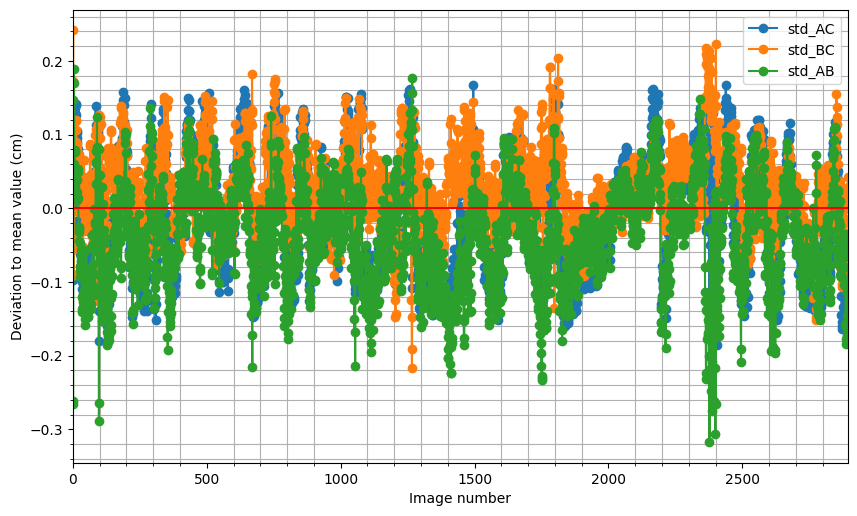

In [8]:
centroids1,centroids2=np.delete(centroids1,false_idx,axis=0),np.delete(centroids2,false_idx,axis=0)
# get fundamental and essential matrices
F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2))
E = np.matmul(cameraMatrix_cam2.T, np.matmul(F, cameraMatrix_cam1))
print("\nEssenc. Mat.\n", E.round(4))
# decompose to rotation and translation between cameras
R, t = decomposeEssentialMat(E, cameraMatrix_cam1, cameraMatrix_cam2, np.array(centroids1), np.array(centroids2))
if np.any(np.isnan(R)): print('no valid rotation matrix')
else:
    print("\nRot. Mat.\n", R.round(4))
    print("\nTrans. Mat.\n", t.round(4))
P1,P2 = np.hstack((cameraMatrix_cam1, [[0.], [0.], [0.]])),np.matmul(cameraMatrix_cam2, np.hstack((R, t.T)))
projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T
if points3d[0, 2] < 0: points3d = -points3d
tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx = 0,15.7,5.5,10.2,[],[],[],0,[]
# compute sdt deviation and plot beautiful stuff
for [A, B, C] in points3d.reshape([-1, 3, 3]):
    L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
    if L_rec_AB<L_rec_BC: L_rec_AB,L_rec_BC=L_rec_BC,L_rec_AB
    tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
    k = k + 3
    lamb = tot/k
    L_AC_vec.append(L_rec_AC)
    L_BC_vec.append(L_rec_BC)
    L_AB_vec.append(L_rec_AB)
print('Scale between real world and triang. point cloud is: ', lamb.round(2))
print('L_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
print('L_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
print('L_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
fig = plt.figure(figsize=(10, 6), dpi=100)
L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
plt.plot(L_AC_vec_plot, '-o', label="std_AC")
plt.plot(L_BC_vec_plot, '-o', label="std_BC")
plt.plot(L_AB_vec_plot, '-o', label="std_AB")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.grid()
#plt.axvline(x=853, c='r', linestyle='--', label="image 960")
plt.xlabel("Image number")
plt.ylabel("Deviation to mean value (cm)")
plt.legend()
ax = fig.axes
ax[0].minorticks_on()
plt.grid(which='both')
plt.xlim(0,len(L_AC_vec)-1)
points3d_new,i= points3d*lamb,0
for [A, B, C] in points3d_new.reshape([-1, 3, 3]):
    L_reconst = np.sqrt(np.sum((A-C)**2, axis=0))
    valid = abs(L_real_AC-L_reconst)/L_real_AC < 0.01
    if not valid: i = i + 1
print("Images distant more than 1% from the real value = " + str(i)+'/'+str(int(points3d.shape[0]/3)))
plt.draw()
plt.show()

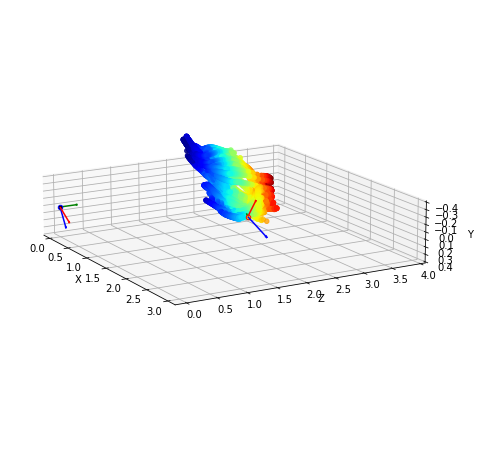

In [9]:
# plot 3d map
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_xlim(-0.1, 3.1)
ax.set_zlim(-0.4, 0.4)
ax.set_ylim(-0.1, 4)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
scale = 0.3
x,y,z = np.array([scale, 0, 0]), np.array([0, scale, 0]),np.array([0, 0, scale])
# rotate second camera to the same plane
t_aux = np.matmul(-t, R)*lamb/100
theta = np.arctan2(t_aux[0][1],t_aux[0][0])
Rz = np.array([[np.cos(-theta),np.sin(-theta),0], [np.sin(-theta), np.cos(-theta),0], [0,0,1]])
x,y,z = np.matmul(Rz, x),np.matmul(Rz, y),np.matmul(Rz, z)
ax.quiver(0, 0, 0, x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r")
ax.quiver(0, 0, 0, y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b")
ax.quiver(0, 0, 0, z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g")
ax.scatter(0, 0, 0, edgecolor="blue", facecolor="black")
x,y,z = np.array([scale, 0, 0]), np.array([0, scale, 0]),np.array([0, 0, scale])
x,y,z = np.matmul(R.T, x),np.matmul(R.T, y),np.matmul(R.T, z)
x,y,z = np.matmul(Rz, x),np.matmul(Rz, y),np.matmul(Rz, z)
t_new,points3d_new = np.matmul(Rz,t_aux.T).T,np.matmul(Rz,points3d.T).T
ax.quiver(t_new[0][0], t_new[0][2], t_new[0][1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r")
ax.quiver(t_new[0][0], t_new[0][2], t_new[0][1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b")
ax.quiver(t_new[0][0], t_new[0][2], t_new[0][1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g")
ax.scatter(t_new[0][0], t_new[0][2], t_new[0][1], edgecolor="r", facecolor="gold")
cmhot = plt.get_cmap("jet")
#ax.view_init(elev=0, azim=-90)  # -37.5,30
#ax.view_init(elev=-70, azim=-120)  # -37.5,30
ax.view_init(elev=15, azim=-30)  # -37.5,30
ax.scatter(points3d_new[:, 0]*lamb/100, points3d_new[:, 2]*lamb/100, points3d_new[:, 1]*lamb/100, c=points3d_new[:, 2], cmap=cmhot)
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .3, 1.]))
plt.draw()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


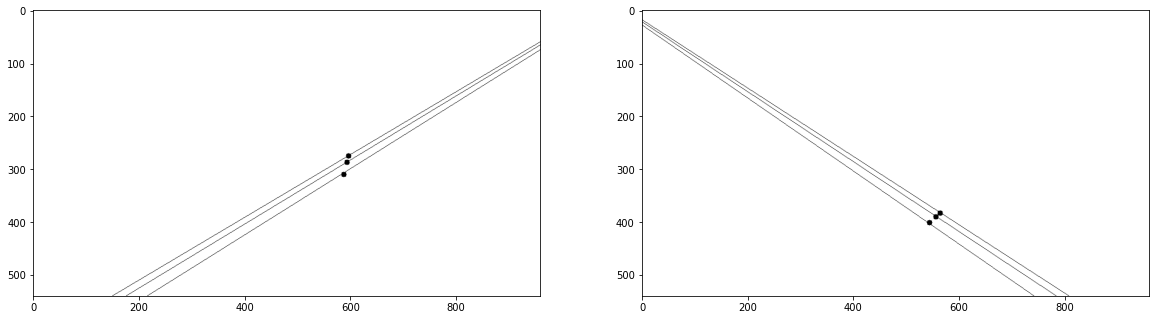

In [10]:
img1,img2,k = np.ones((540,960))*255,np.ones((540,960))*255,0
pts1,pts2 = np.int32(centroids1[0:3].reshape(-1,2)),np.int32(centroids2[0:3].reshape(-1,2))

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2BGR)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = (0,0,0)
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = line(img1, (x0,y0), (x1,y1), color,1)
        img1 = circle(img1,tuple(pt1),5,color,-1)
        img2 = circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

lines1 = computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
lines2 = computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(20, 16))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()
